In [118]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

In [119]:
df = pd.read_csv('bos_mar2014.csv', header=0)
df['genderbool'] = np.where(df['gender'] == 'M', 1, 0)
df['25k'] = pd.to_numeric(df['25k'], errors='coerce')
df['10k'] = pd.to_numeric(df['10k'], errors='coerce')
df['official'] = pd.to_numeric(df['official'], errors='coerce')
df['35k'] = pd.to_numeric(df['35k'], errors='coerce')
df['40k'] = pd.to_numeric(df['40k'], errors='coerce')
df['30k'] = pd.to_numeric(df['30k'], errors='coerce')
df['half'] = pd.to_numeric(df['half'], errors='coerce')
df['5k'] = pd.to_numeric(df['5k'], errors='coerce')
df['20k'] = pd.to_numeric(df['20k'], errors='coerce')
df['age_group'] = pd.cut(df['age'], bins=8)
df = df.dropna(subset=['25k', '10k', 'official', '35k', '40k',
                      '30k', 'half', '5k', '20k'])
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,state,30k,5k,half,20k,country,city,40k,genderbool,age_group
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1,"(41.625, 49.5]"
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,0,"(25.875, 33.75]"
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1,"(33.75, 41.625]"
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,0,"(17.937, 25.875]"
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1,"(33.75, 41.625]"


In [120]:
df.dtypes

10k            float64
name            object
division         int64
25k            float64
gender          object
age              int64
official       float64
bib             object
genderdiv        int64
ctz             object
35k            float64
overall          int64
pace           float64
state           object
30k            float64
5k             float64
half           float64
20k            float64
country         object
city            object
40k            float64
genderbool       int64
age_group     category
dtype: object

In [121]:
df.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,genderbool
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,1922.747291,133.581175,42.385067,241.952383,8002.921988,196.033373,15833.958924,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990,0.552435
std,8.710102,1704.843679,25.571480,11.299795,50.842552,4733.255987,40.775036,9182.223743,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493,0.497251
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000,0.000000
25%,45.370000,607.000000,115.430000,33.000000,205.300000,3940.000000,166.950000,7880.000000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000,0.000000
50%,50.280000,1418.000000,128.850000,42.000000,231.980000,7919.000000,187.850000,15829.000000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000,1.000000
75%,57.000000,2601.000000,147.700000,50.000000,272.200000,11893.000000,219.370000,23785.000000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000,1.000000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000,1.000000


In [122]:
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]

X = df[['10k', '25k', '35k', '30k', '5k', '20k', '40k']]
y = df['age_group']

X_norm = normalize(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
ypred = pd.DataFrame()

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

In [123]:
# KMeans
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

#y_pred = KMeans(n_clusters=2, n_init=1, random_state=42).fit_predict(X_train)

#plt.scatter(X_train[:,0], X_train[:, 1], c=y_pred)
#plt.show()

#print(pd.crosstab(y_pred, y_train))

IndentationError: unexpected indent (<ipython-input-123-e53c885caabb>, line 3)

KeyError: 'clust2_sample0'

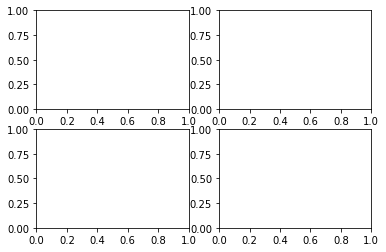

In [124]:
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [125]:
full_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_norm)

print(pd.crosstab(y, full_pred))

col_0                0    1     2     3    4
age_group                                   
(17.937, 25.875]   655   37   604   518  197
(25.875, 33.75]   1864   84  2098  1300  572
(33.75, 41.625]   2246   94  2502  1462  622
(41.625, 49.5]    2779  119  2694  1764  690
(49.5, 57.375]    2007   95  1625  1361  651
(57.375, 65.25]    853   52   486   625  323
(65.25, 73.125]    207   17    75   200  105
(73.125, 81.0]      20    3     7    21   14


In [126]:
from sklearn import metrics
    
metrics.adjusted_rand_score(full_pred, y)

0.00595516128139631

In [127]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.516122619733881
0.5208228277209231
0.5274360011425152
0.5245048400192668


Number of estimated clusters: 9


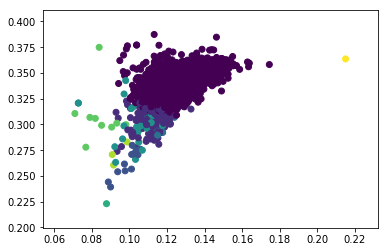

Comparing the assigned categories to the ones in the data:
col_0                0   1  2  3   4  5  6  7  8
age_group                                       
(17.937, 25.875]  1991  12  0  4   3  0  1  0  0
(25.875, 33.75]   5849  47  1  6  13  0  1  1  0
(33.75, 41.625]   6862  45  4  7   5  1  1  1  0
(41.625, 49.5]    7987  48  2  3   3  0  3  0  0
(49.5, 57.375]    5680  45  2  3   7  0  2  0  0
(57.375, 65.25]   2312  20  1  3   0  0  1  1  1
(65.25, 73.125]    595   6  2  1   0  0  0  0  0
(73.125, 81.0]      62   3  0  0   0  0  0  0  0


In [128]:
# Mean Shift
#X = df[['10k', '25k', '35k', '30k', '5k', '20k', '40k']]
#X_norm = normalize(X)

bandwidth = estimate_bandwidth(X_norm, quantile=0.8, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_)

labels = ms.labels_

cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, labels))

In [131]:
for sample in [X1, X2, X3, X4]:
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.6576752550242436
0.6424085182077278
0.5902040362845447
0.4804849460198999


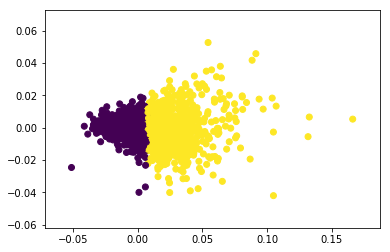

Comparing the assigned categories to the ones in the data:
col_0             0    1
age_group               
(17.937, 24.3]   90   61
(24.3, 30.6]    308  138
(30.6, 36.9]    310  143
(36.9, 43.2]    459  160
(43.2, 49.5]    430  172
(49.5, 55.8]    322  152
(55.8, 62.1]    173  113
(62.1, 68.4]     53   46
(68.4, 74.7]     10   18
(74.7, 81.0]      2    4


In [18]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=2

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters, affinity='rbf')
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))
print(metrics.silhouette_score())

In [38]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))
print(metrics.silhouette_score(X_train, labels, metric='euclidean'))

Done
Estimated number of clusters: 229
0.2078754841186024


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


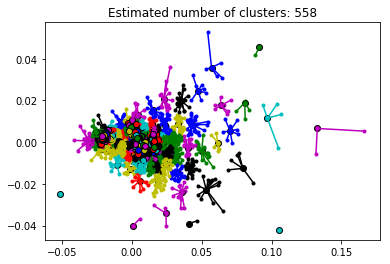

In [18]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
            cluster_center[1],
            'o',
            markerfacecolor=col,
            markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
        
plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()